In [ ]:
'''Starter Code for the Cookie Regression Challenge'''

In [ ]:
#importing libraries
from scipy.optimize import curve_fit, least_squares
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df = pd.read_csv('data/triangle_data.csv')
x = df['x'].values
y = df['y'].values
print(x.max(), x.min())

2.6799637057196946 -2.685263761015128


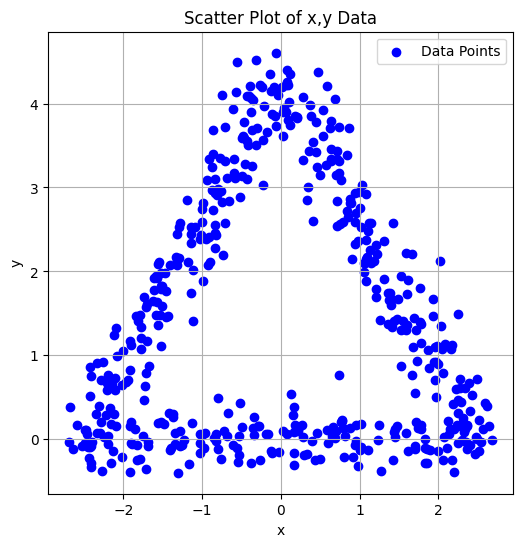

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label="Data Points", color='blue')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter Plot of x,y Data")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from scipy.spatial import ConvexHull

Data loaded successfully from 'data/triangle_data.csv'.
Convex hull has 17 vertices. Selecting 3 sharpest.
Selected vertex indices (original hull): [1, 9, 11]
Identified Vertices:
[[-5.60314444e-01  4.49625818e+00]
 [ 2.20371511e+00 -3.90417560e-01]
 [ 2.67996371e+00 -3.32637378e-03]]
Using distance threshold for point selection: 0.0921

Processing edge: V1 -> V2
  Vertices: (-0.56, 4.50) to (2.20, -0.39)
  Found 23 points near this segment.
  Fitted line: y = -1.7374*x + 3.4935

Processing edge: V2 -> V3
  Vertices: (2.20, -0.39) to (2.68, -0.00)
  Found 5 points near this segment.
  Fitted line: y = 0.8534*x + -2.2656

Processing edge: V3 -> V1
  Vertices: (2.68, -0.00) to (-0.56, 4.50)
  Found 55 points near this segment.
  Fitted line: y = -1.3904*x + 3.7160


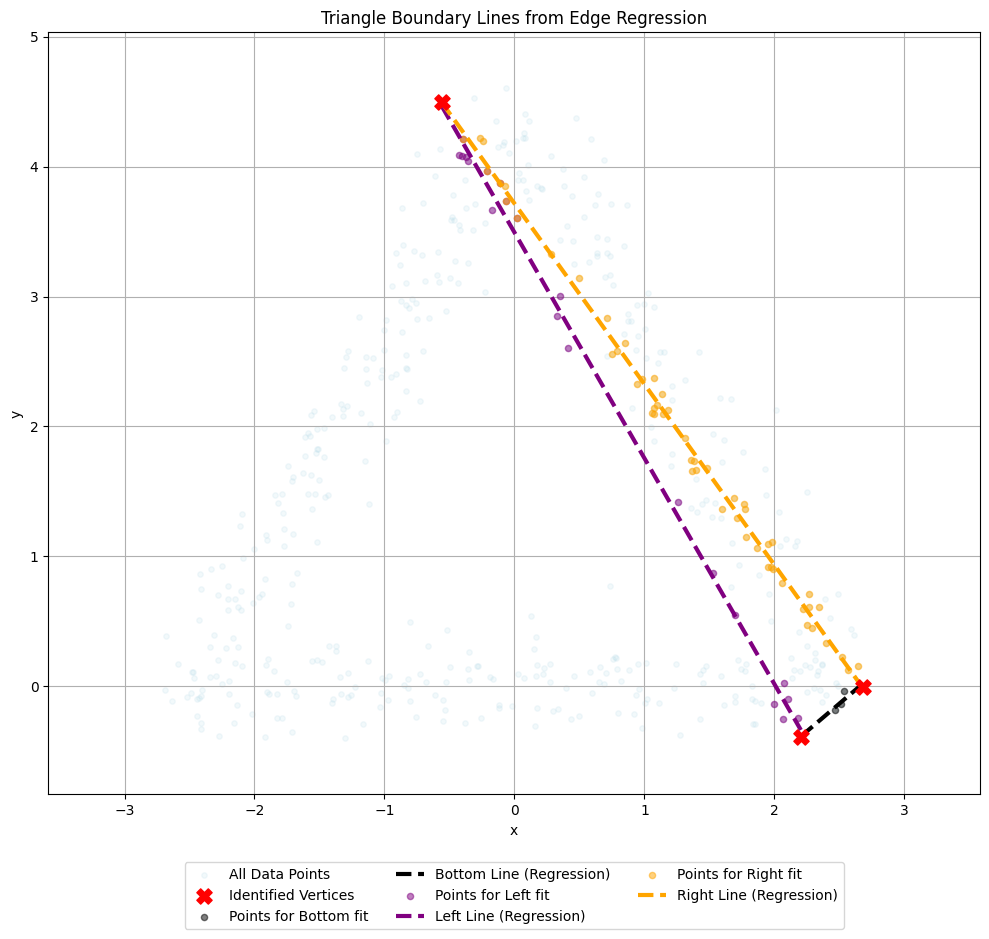


--- Final Functions and Bounds (Edge Regression) ---
Bottom: y = 0.8534*x + -2.2656, Bounds: [2.2037, 2.6800]
Left: y = -1.7374*x + 3.4935, Bounds: [-0.5603, 2.2037]
Right: y = -1.3904*x + 3.7160, Bounds: [-0.5603, 2.6800]


In [17]:
# ... (Imports: pandas, numpy, ConvexHull, pyplot, LinearRegression) ...
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- Load data (using placeholder/dummy if file not found) ---
try:
    df = pd.read_csv('data/triangle_data.csv')
    print(f"Data loaded successfully from 'data/triangle_data.csv'.")
except FileNotFoundError:
    print("Error: 'data/triangle_data.csv' not found. Using dummy data.")
    np.random.seed(42)
    v1 = np.array([1, 1]); v2 = np.array([9, 3]); v3 = np.array([5, 8])
    n_points = 500; s = np.random.rand(n_points, 1); t = np.random.rand(n_points, 1)
    is_outside = s + t > 1
    s[is_outside] = 1 - s[is_outside]; t[is_outside] = 1 - t[is_outside]
    points_arr = v1 + s * (v2 - v1) + t * (v3 - v1)
    # Make edges "thicker" with noise perpendicular to edges
    noise_scale = 0.4
    edge1_norm = (v2-v1)/np.linalg.norm(v2-v1)
    edge1_perp = np.array([-edge1_norm[1], edge1_norm[0]])
    edge2_norm = (v3-v2)/np.linalg.norm(v3-v2)
    edge2_perp = np.array([-edge2_norm[1], edge2_norm[0]])
    edge3_norm = (v1-v3)/np.linalg.norm(v1-v3)
    edge3_perp = np.array([-edge3_norm[1], edge3_norm[0]])
    noise = np.zeros_like(points_arr)
    # Apply noise mostly perpendicular to the nearest edge (simplified logic here)
    noise += (np.random.randn(n_points, 1) * edge1_perp * noise_scale)
    noise += (np.random.randn(n_points, 1) * edge2_perp * noise_scale * 0.7) # less noise maybe
    noise += (np.random.randn(n_points, 1) * edge3_perp * noise_scale * 0.5)
    points_arr += noise * (1-s-t)*2 # More noise near center? No, maybe less noise near center
    df = pd.DataFrame(points_arr, columns=['x', 'y'])

except Exception as e:
    print(f"Error loading or processing CSV: {e}")
    exit()
# --- End of data loading ---

# --- Helper function to calculate vertex angles ---
def get_vertex_angles(hull_points):
    # (Same as before)
    angles = []
    num_vertices = len(hull_points)
    for i in range(num_vertices):
        p_prev = hull_points[(i - 1 + num_vertices) % num_vertices]
        p_curr = hull_points[i]
        p_next = hull_points[(i + 1) % num_vertices]
        vec1 = p_prev - p_curr
        vec2 = p_next - p_curr
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        if norm1 == 0 or norm2 == 0: angle_rad = np.pi
        else:
            vec1_norm = vec1 / norm1; vec2_norm = vec2 / norm2
            dot_p = np.clip(np.dot(vec1_norm, vec2_norm), -1.0, 1.0)
            angle_rad = np.arccos(dot_p)
        angles.append({'index': i, 'angle': angle_rad})
    return angles

# --- Function to find the 3 primary triangle vertices ---
def find_triangle_vertices(dataframe):
    """Finds the 3 primary vertices of the triangle boundary."""
    points = dataframe[['x', 'y']].values
    if len(points) < 3: return None
    try:
        hull = ConvexHull(points)
        hull_points_all = points[hull.vertices]
        num_vertices_all = len(hull_points_all)
        if num_vertices_all < 3: return None

        if num_vertices_all == 3:
            print("Convex hull has exactly 3 vertices.")
            return hull_points_all
        else:
            print(f"Convex hull has {num_vertices_all} vertices. Selecting 3 sharpest.")
            vertex_angles = get_vertex_angles(hull_points_all)
            vertex_angles.sort(key=lambda item: item['angle'])
            selected_indices = sorted([item['index'] for item in vertex_angles[:3]])
            selected_vertices = hull_points_all[selected_indices]
            print(f"Selected vertex indices (original hull): {selected_indices}")
            return selected_vertices
    except Exception as e:
        print(f"An error occurred during vertex finding: {e}")
        return None

# --- Function to get points near a line segment ---
def get_points_near_segment(df, v1, v2, threshold):
    """Selects points from df close to the segment v1-v2."""
    points = df[['x', 'y']].values
    v1 = np.array(v1); v2 = np.array(v2)
    segment_vec = v2 - v1
    segment_len_sq = np.dot(segment_vec, segment_vec)

    if segment_len_sq < 1e-9: # Avoid division by zero for zero-length segment
        return pd.DataFrame(columns=['x', 'y'])

    # Project points onto the line defined by the segment
    # Vector from v1 to point p: p - v1
    # Projection factor t = dot(p - v1, segment_vec) / segment_len_sq
    p_minus_v1 = points - v1
    t = np.dot(p_minus_v1, segment_vec) / segment_len_sq

    # Projections of points onto the line
    projections = v1 + t[:, np.newaxis] * segment_vec

    # Calculate perpendicular distance squared: dist_sq = || p - projection ||^2
    dist_sq = np.sum((points - projections)**2, axis=1)

    # Select points close to the line AND whose projection lies within the segment
    # Check if 0 <= t <= 1 for projection to be within segment
    mask = (dist_sq < threshold**2) & (t >= -0.01) & (t <= 1.01) # Add small tolerance

    return df[mask]

# --- Function to classify lines (adapts to new line dictionary structure) ---
def classify_regressed_lines(lines):
    """Classifies 3 regressed lines into 'bottom', 'left', 'right'."""
    if not lines or len(lines) != 3:
        print("Warning: Cannot classify lines, expected exactly 3.")
        return None

    # Use midpoints of the *original defining vertices* for classification robustness
    for line in lines:
        v1 = line['v1']; v2 = line['v2']
        line['mid_y'] = (v1[1] + v2[1]) / 2
        line['mid_x'] = (v1[0] + v2[0]) / 2

    lines.sort(key=lambda l: l['mid_y'])
    line_bottom = lines[0]
    other_lines = lines[1:]
    other_lines.sort(key=lambda l: l['mid_x'])
    line_left = other_lines[0]
    line_right = other_lines[1]

    return {"Bottom": line_bottom, "Left": line_left, "Right": line_right}

# --- Main Execution ---

# 1. Find the 3 primary vertices
vertices = find_triangle_vertices(df.copy()) # Use copy

if vertices is None or len(vertices) != 3:
    print("Could not determine 3 triangle vertices. Exiting.")
    exit()

print("Identified Vertices:")
print(vertices)

# 2. Determine distance threshold (heuristic: % of shortest edge length)
edge_lengths = [np.linalg.norm(vertices[i] - vertices[(i + 1) % 3]) for i in range(3)]
if not edge_lengths or min(edge_lengths) < 1e-6:
     print("Warning: Very short edge detected, using default threshold.")
     threshold_distance = 0.5 # Default absolute threshold
else:
     # Use 15% of the shortest edge as a threshold? Adjust as needed.
     threshold_distance = 0.15 * min(edge_lengths)
print(f"Using distance threshold for point selection: {threshold_distance:.4f}")


# 3. Select points and perform regression for each edge
fitted_lines = []
for i in range(3):
    v_start = vertices[i]
    v_end = vertices[(i + 1) % 3] # Wrap around

    print(f"\nProcessing edge: V{i+1} -> V{(i+1)%3+1}")
    print(f"  Vertices: ({v_start[0]:.2f}, {v_start[1]:.2f}) to ({v_end[0]:.2f}, {v_end[1]:.2f})")

    # Select points near this edge segment
    edge_points = get_points_near_segment(df, v_start, v_end, threshold_distance)
    print(f"  Found {len(edge_points)} points near this segment.")

    if len(edge_points) < 5: # Need sufficient points for meaningful regression
        print(f"  Warning: Insufficient points near edge V{i+1}-V{(i+1)%3+1} for reliable regression.")
        continue # Skip this edge

    # Perform Linear Regression
    X = edge_points[['x']].values
    y = edge_points['y'].values
    model = LinearRegression()
    try:
        model.fit(X, y)
        m = model.coef_[0]
        b = model.intercept_

        # Use vertex x-coords for bounds
        xmin = min(v_start[0], v_end[0])
        xmax = max(v_start[0], v_end[0])
        equation_str = f"y = {m:.4f}*x + {b:.4f}"
        print(f"  Fitted line: {equation_str}")

        fitted_lines.append({
            'equation_str': equation_str, 'm': m, 'b': b,
            'bounds': (xmin, xmax),
            'v1': v_start, 'v2': v_end # Store original vertices for classification
        })
    except Exception as e:
         print(f"  Error during regression for edge V{i+1}-V{(i+1)%3+1}: {e}")


# 4. Classify the fitted lines
classified_lines = None
if len(fitted_lines) == 3:
     classified_lines = classify_regressed_lines(fitted_lines)
else:
     print(f"\nCould not fit lines for all 3 edges (found {len(fitted_lines)}). Classification skipped.")


# 5. Visualization
if classified_lines:
    plt.figure(figsize=(10, 10)) # Larger figure
    # Plot all data points
    plt.scatter(df['x'], df['y'], alpha=0.15, label='All Data Points', s=15, color='lightblue')

    # Plot selected vertices
    vert_arr = np.array(vertices)
    plt.scatter(vert_arr[:, 0], vert_arr[:, 1], color='red', s=120, label='Identified Vertices', zorder=6, marker='X')

    # Plot fitted lines and highlight points used for each fit
    colors = {'Bottom': 'black', 'Left': 'purple', 'Right': 'orange'}
    plot_order = ["Bottom", "Left", "Right"]

    for label in plot_order:
        line = classified_lines[label]
        v1 = line['v1']; v2 = line['v2']
        color = colors[label]

        # Highlight points used for this line's fit
        points_used = get_points_near_segment(df, v1, v2, threshold_distance)
        plt.scatter(points_used['x'], points_used['y'], alpha=0.5, s=20, label=f'Points for {label} fit', color=color, zorder=3)

        # Plot the fitted line itself
        xmin, xmax = line['bounds']
        x_vals = np.array([xmin, xmax])
        y_vals = line['m'] * x_vals + line['b']
        plt.plot(x_vals, y_vals, lw=3, label=f'{label} Line (Regression)', color=color, zorder=4, linestyle='--')

        # Optionally plot original hull segment for comparison
        # plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color=color, linestyle=':', lw=1, label=f'{label} Hull Segment')


    plt.title('Triangle Boundary Lines from Edge Regression')
    plt.xlabel('x')
    plt.ylabel('y')
    # Adjust legend location if it overlaps too much
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3)
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to prevent legend cutoff
    plt.show()

# 6. Format the final output
final_submission = ""
if classified_lines:
    print("\n--- Final Functions and Bounds (Edge Regression) ---")
    output_string = ""
    plot_order = ["Bottom", "Left", "Right"]
    for label in plot_order:
        line = classified_lines[label]
        output_string += f"{label}: {line['equation_str']}, Bounds: [{line['bounds'][0]:.4f}, {line['bounds'][1]:.4f}]\n"
    final_submission = output_string.strip()
    print(final_submission)
else:
     print("\nCould not determine classified triangle boundary lines using edge regression.")
     final_submission = "Error: Could not determine classified triangle boundary lines."

# --- SUBMIT THE CONTENT OF final_submission ---

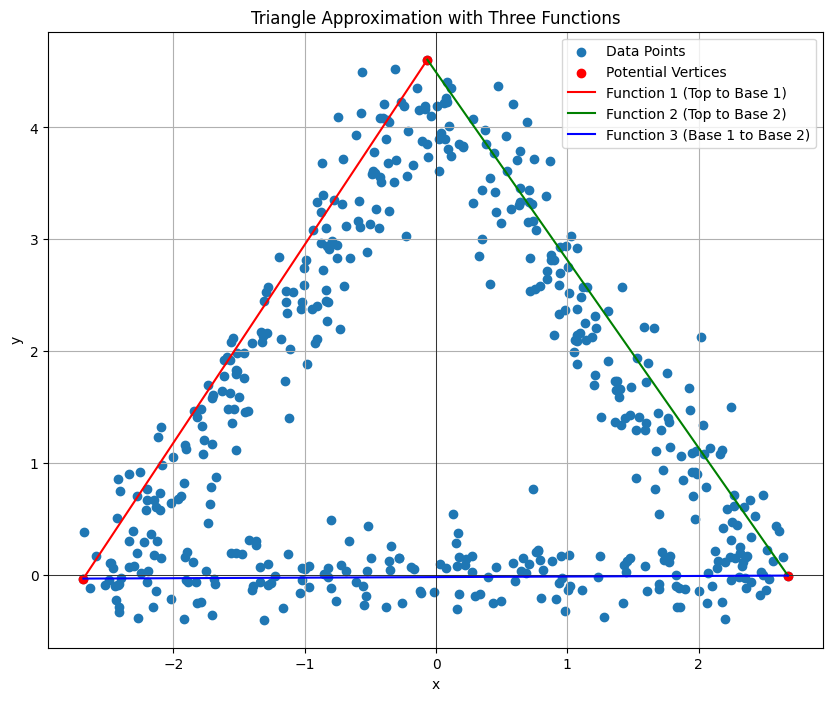


Submitted Function 1:
1.7696*x + 4.7217
x-bounds: [np.float64(-2.685263761015128), np.float64(-0.0660556844480264)]

Submitted Function 2:
-1.6781*x + 4.4940
x-bounds: [np.float64(-0.0660556844480264), np.float64(2.6799637057196946)]

Submitted Function 3:
0.0050*x + -0.0167
x-bounds: [np.float64(-2.685263761015128), np.float64(2.6799637057196946)]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
try:
    df = pd.read_csv('data/triangle_data.csv')
    points = df[['x', 'y']].values
except FileNotFoundError:
    print("Error: triangle_data.csv not found. Please make sure the file is in the correct directory.")
    raise FileNotFoundError("triangle_data.csv not found. Please make sure the file is in the correct directory.")

# 1. Sort points by x-coordinate
sorted_indices_x = np.argsort(points[:, 0])
sorted_points_x = points[sorted_indices_x]

# 2. Identify potential "top" vertex (highest or lowest y in a central x-range)
x_range_start = int(len(sorted_points_x) * 0.3)
x_range_end = int(len(sorted_points_x) * 0.7)
central_points = sorted_points_x[x_range_start:x_range_end]

if len(central_points) > 0:
    top_vertex = central_points[np.argmax(central_points[:, 1])]
else:
    print("Warning: Could not identify a clear top vertex based on x-range.")
    top_vertex = sorted_points_x[len(sorted_points_x) // 2]

# 3. Identify potential "base" vertices (extremes in x)
base_vertex1 = sorted_points_x[0]  # Leftmost point
base_vertex2 = sorted_points_x[-1] # Rightmost point

# 4. Define the three functions (lines forming the sides)
def line_equation(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    if x2 - x1 == 0:
        return float('inf'), float('inf')
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    return m, c

# Function 1: Top vertex to base_vertex1 (left side)
m1, c1 = line_equation(top_vertex, base_vertex1)
x_bounds1 = [min(top_vertex[0], base_vertex1[0]), max(top_vertex[0], base_vertex1[0])]
func1_str = f"{m1:.4f}*x + {c1:.4f}"

# Function 2: Top vertex to base_vertex2 (right side)
m2, c2 = line_equation(top_vertex, base_vertex2)
x_bounds2 = [min(top_vertex[0], base_vertex2[0]), max(top_vertex[0], base_vertex2[0])]
func2_str = f"{m2:.4f}*x + {c2:.4f}"

# Function 3: Base vertex 1 to base vertex 2 (bottom)
m3, c3 = line_equation(base_vertex1, base_vertex2)
x_bounds3 = [min(base_vertex1[0], base_vertex2[0]), max(base_vertex1[0], base_vertex2[0])]
func3_str = f"{m3:.4f}*x + {c3:.4f}"

# 5. Plot the data and the three functions
plt.figure(figsize=(10, 8))
plt.scatter(points[:, 0], points[:, 1], label='Data Points')
plt.scatter([top_vertex[0], base_vertex1[0], base_vertex2[0]],
            [top_vertex[1], base_vertex1[1], base_vertex2[1]], color='red', label='Potential Vertices')
plt.title('Triangle Approximation with Three Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

x_fit1 = np.linspace(x_bounds1[0], x_bounds1[1], 100)
y_fit1 = m1 * x_fit1 + c1
plt.plot(x_fit1, y_fit1, 'r-', label=f'Function 1 (Top to Base 1)')

x_fit2 = np.linspace(x_bounds2[0], x_bounds2[1], 100)
y_fit2 = m2 * x_fit2 + c2
plt.plot(x_fit2, y_fit2, 'g-', label=f'Function 2 (Top to Base 2)')

x_fit3 = np.linspace(x_bounds3[0], x_bounds3[1], 100)
y_fit3 = m3 * x_fit3 + c3
plt.plot(x_fit3, y_fit3, 'b-', label=f'Function 3 (Base 1 to Base 2)')

plt.legend()
plt.show()

# 6. Print the submitted functions and bounds
print("\nSubmitted Function 1:")
print(func1_str)
print("x-bounds:", x_bounds1)

print("\nSubmitted Function 2:")
print(func2_str)
print("x-bounds:", x_bounds2)

print("\nSubmitted Function 3:")
print(func3_str)
print("x-bounds:", x_bounds3)